# Data Analysis

## Preparing The Data

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
def data(root: Path) -> Path:
    return root / "data"


def output(root: Path) -> Path:
    return data(root) / "output"


def raw_results(root: Path) -> Path:
    return data(root) / "raw_results" / "raw_results.csv"


def subjects(root: Path) -> Path:
    return data(root) / "raw_results" / "subjects.csv"


def commits(root: Path) -> Path:
    return data(root) / "raw_results" / "commits.csv"


def truth(root: Path) -> Path:
    return data(root) / "truth" / "truth.csv"


In [3]:
raw_results_df = pd.read_csv(
    raw_results(Path.cwd()),
    low_memory=False,
)

In [4]:
df = raw_results_df.copy()

for column in [
    "full_name",
    "clone_url",
    "git_url",
    "teams_url",
    "sha",
    "url",
    "message",
]:
    if column in df.columns:
        df = df.drop(columns=[column])

In [5]:
if df["is_ccdc_event"].isna().any():
    n = int(df["is_ccdc_event"].isna().sum())
    print(f"WARNING: {n} rows have non-parseable is_ccdc_event -> NaN")

def to_bool(series: pd.Series) -> pd.Series:
    if series.dtype == bool:
        return series
    s = series.astype("string").str.strip().str.lower()
    mapping = {"true": True, "false": False}
    return s.map(mapping)

df["is_ccdc_event"] = to_bool(df["is_ccdc_event"])

In [6]:
df["detected_channel"] = df["detected_channel"].astype("string").fillna("")

In [7]:
key_cols = ["full_name_of_repo", "commit_sha", "path"]

gb = df.groupby(key_cols, dropna=False)

def agg_channels(x: pd.Series) -> tuple[str, ...]:
    vals = [
        v
        for v in x.astype("string").tolist()
        if isinstance(v, str) and v.strip() != ""
    ]
    return tuple(sorted(set(vals)))

agg = gb.agg(
    is_ccdc_event=("is_ccdc_event", "first"),
    date=("date", "first"),
    detected_channels=("detected_channel", agg_channels),
)

for column in [
    "id",
    "homepage",
    "created_at",
    "pushed_at",
    "updated_at",
    "has_discussions",
    "has_issues",
    "has_pages",
    "has_projects",
    "has_wiki",
    "forks_count",
    "open_issues_count",
    "stargazers_count",
    "subscribers_count",
    "size",
]:
    if column in df.columns:
        agg[column] = gb[column].first()

agg = agg.reset_index()

df = agg

In [8]:
date_cols = ["created_at", "pushed_at", "updated_at", "date"]

for column in date_cols:
    if column in df.columns:
        df[column] = pd.to_datetime(df[column], errors="coerce", utc=True)

In [9]:
rowwise_min = df[["date", "created_at"]].min(axis=1)

df["birthday"] = (
    rowwise_min
        .groupby(df["full_name_of_repo"], dropna=False)
        .transform("min")
)

In [10]:
df["age_in_days"] = (
    (df["date"] - df["birthday"]).to_numpy()
    / np.timedelta64(1, "D")
)

In [11]:
AGE_GROUPS_YEARS = [
    (0, 1, "0-1"),
    (1, 2, "1-2"),
    (2, 3, "2-3"),
    (3, 4, "3-4"),
    (4, 5, "4-5"),
    (5, 6, "5-6"),
    (6, 7, "6-7"),
    (7, 8, "7-8"),
    (8, 9, "8-9"),
    (9, 10, "9-10"),
    (10, 11, "10-11"),
    (11, 12, "11-12"),
    (12, 13, "12-13"),
    (13, 14, "13-14"),
    (14, 15, "14-15"),
    (15, 999, "15+"),
]


def assign_age_group_and_index(age_in_days: float) -> tuple[str, int | None]:
    if pd.isna(age_in_days):
        return "unknown", None
    for lo, hi, label in AGE_GROUPS_YEARS:
        if lo * 365.25 <= age_in_days < hi * 365.25:
            return label, lo
    return "unknown", None


df[["repo_age_group_at_commit", "repo_age_group_index"]] = (
    df["age_in_days"]
      .apply(assign_age_group_and_index)
      .apply(pd.Series)
)

df["repo_age_group_at_commit"].value_counts(dropna=False)

repo_age_group_at_commit
0-1      6397
1-2      2430
2-3      1995
3-4      1439
4-5      1214
5-6      1024
6-7       895
7-8       674
8-9       586
9-10      377
10-11     320
11-12     163
12-13     120
13-14      42
14-15      11
15+         7
Name: count, dtype: int64

In [12]:
subjects = df.copy()

for column in [
    "id",
    "homepage",
    "pushed_at",
    "updated_at",
    "has_discussions",
    "has_issues",
    "has_pages",
    "has_projects",
    "has_wiki",
    "forks_count",
    "open_issues_count",
    "stargazers_count",
    "subscribers_count",
    "size",
    "birthday",
]:
    if column in subjects.columns:
        subjects = subjects.drop(columns=[column])

In [13]:
subjects = subjects.sort_values(
    by=["full_name_of_repo", "date", "commit_sha", "path"],
    ascending=[True, True, True, True],
).reset_index(drop=True)
subjects["subject_id"] = df.index
subjects = subjects.set_index("subject_id")

subjects.head(30)

,full_name_of_repo,commit_sha,path,is_ccdc_event,date,detected_channels,created_at,age_in_days,repo_age_group_at_commit,repo_age_group_index
subject_id,,,,,,,,,,
0,05bit/peewee-async,fc8edc1d35cbda8477ceb4dd672d2ed115b18635,README.md,False,2014-09-27 22:15:28+00:00,(),2014-09-27 22:15:28+00:00,0.000000,0-1,0
1,05bit/peewee-async,03d7da284e47d3018e071995e2d9cd7a8625f41e,README.md,True,2014-09-28 13:44:56+00:00,"(issues,)",2014-09-27 22:15:28+00:00,0.645463,0-1,0
2,05bit/peewee-async,53130218e08eaacf34f3d68338bb008fdfeb6c72,README.md,False,2014-09-28 13:49:37+00:00,(),2014-09-27 22:15:28+00:00,0.648715,0-1,0
3,05bit/peewee-async,c90ae2ca4a4d6cdac078e9918c53e9ea0ddcb632,README.md,False,2014-09-29 10:33:36+00:00,(),2014-09-27 22:15:28+00:00,1.512593,0-1,0
4,05bit/peewee-async,4db3f204d4ee60a91146e27d3d82b9edfc1086c2,README.md,False,2014-10-11 09:08:29+00:00,(),2014-09-27 22:15:28+00:00,13.453484,0-1,0
5,05bit/peewee-async,f546a0d2c41b2c29f718ec4f6459c44eedd00983,README.md,False,2014-10-11 12:07:44+00:00,(),2014-09-27 22:15:28+00:00,13.577963,0-1,0
6,05bit/peewee-async,95506301a3c0279812ee6802e30f1741435c5aca,README.md,False,2014-10-11 12:11:48+00:00,(),2014-09-27 22:15:28+00:00,13.580787,0-1,0
7,05bit/peewee-async,eead5b75cf1ef4c06cfce3d09184230b4e64ffa8,README.md,False,2014-10-11 14:38:03+00:00,(),2014-09-27 22:15:28+00:00,13.682350,0-1,0
8,05bit/peewee-async,7bce99a67f17685aeec8f756908f8ad19a2cd82e,README.md,False,2014-10-11 15:09:02+00:00,(),2014-09-27 22:15:28+00:00,13.703866,0-1,0


In [14]:
repos = df.groupby("full_name_of_repo").agg(
    id=("id", "first"),
    created_at=("created_at", "first"),
    birthday=("birthday", "first"),
    pushed_at=("pushed_at", "first"),
    updated_at=("updated_at", "first"),
    homepage=("homepage", "first"),
    has_discussions=("has_discussions", "first"),
    has_issues=("has_issues", "first"),
    has_pages=("has_pages", "first"),
    has_projects=("has_projects", "first"),
    has_wiki=("has_wiki", "first"),
    forks_count=("forks_count", "first"),
    open_issues_count=("open_issues_count", "first"),
    stargazers_count=("stargazers_count", "first"),
    subscribers_count=("subscribers_count", "first"),
    size=("size", "first"),
).reset_index()

repos["last_activity"] = repos[["pushed_at", "updated_at"]].max(axis=1)

repos["age"] = repos["last_activity"] - repos["birthday"]

In [15]:
repos = repos[[
    "id",
    "full_name_of_repo",
    "created_at",
    "pushed_at",
    "updated_at",
    "birthday",
    "last_activity",
    "age",
]]

## Descriptive Statistics

### Functions

In [16]:
import pandas as pd

def boxplot_stats(s: pd.Series) -> pd.Series:
    s = s.dropna()

    q1 = s.quantile(0.25)
    q2 = s.quantile(0.50)
    q3 = s.quantile(0.75)
    iqr = q3 - q1

    lower_whisker = s[s >= q1 - 1.5 * iqr].min()
    upper_whisker = s[s <= q3 + 1.5 * iqr].max()

    n_outliers = ((s < lower_whisker) | (s > upper_whisker)).sum()

    return pd.Series({
        "q1": q1,
        "median": q2,
        "q3": q3,
        "iqr": iqr,
        "lower_whisker": lower_whisker,
        "upper_whisker": upper_whisker,
        "n_outliers": n_outliers,
        "min": s.min(),
        "max": s.max(),
        "n": len(s),
    })

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

def seaborn_boxplots(
    df,
    columns,
    *,
    figsize=(6, 4),
    showfliers=True,
):
    cols = list(columns)
    n = len(cols)

    fig, axes = plt.subplots(
        nrows=n,
        ncols=1,
        figsize=(figsize[0], figsize[1] * n),
        constrained_layout=True,
    )

    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, cols):
        sns.boxplot(
            y=df[col],
            ax=ax,
            showfliers=showfliers,
        )
        ax.set_title(col)
        ax.set_xlabel("")

    plt.show()

TODO: Remove

In [18]:
def summarize_subjects(g: pd.DataFrame) -> pd.Series:
    n_repos = g["full_name_of_repo"].nunique()
    n_commits = g["commit_sha"].nunique()
    n_distinct_paths = g["path"].nunique()
    n_subjects = len(g)
    positives = g["is_ccdc_event"]
    negatives = ~positives
    n_positives = positives.sum()
    n_negatives = negatives.sum()
    positive_rate = (n_positives / n_subjects) if n_subjects else np.nan
    channels = (
        g["detected_channels"]
        .explode()
        .dropna()    
    )
    n_distinct_channels = len(channels.unique())
    has_channel = g["detected_channels"] != ()
    no_channel = g["detected_channels"] == ()
    n_positives_with_channel = (positives & has_channel).sum()
    n_positives_without_channel = (positives & no_channel).sum()
    n_negatives_with_channel = (negatives & has_channel).sum()
    n_negatives_without_channel = (negatives & no_channel).sum()
    path_vc = (
        g["path"]
        .value_counts()
    )
    most_popular_path = path_vc.idxmax()
    least_popular_path = path_vc.idxmin()
    channels_vc = (
        channels
        .value_counts()
    )
    most_frequently_detected_channel = channels_vc.idxmax()
    least_commonly_detected_channel = channels_vc.idxmin()
    return pd.Series(
        {
            "n_repos": n_repos,
            "n_commits": n_commits,
            "n_distinct_paths": n_distinct_paths,
            "n_subjects": n_subjects,
            "n_positives": n_positives,
            "n_negatives": n_negatives,
            "positive_rate": positive_rate,
            "n_distinct_channels": n_distinct_channels,
            "n_positives_with_channel": n_positives_with_channel,
            "n_positives_without_channel": n_positives_without_channel,
            "n_negatives_with_channel": n_negatives_with_channel,
            "n_negatives_without_channel": n_negatives_without_channel,
            "most_popular_path": most_popular_path,
            "least_popular_path": least_popular_path,
            "most_frequently_detected_channel": most_frequently_detected_channel,
            "least_commonly_detected_channel": least_commonly_detected_channel,
        }
    )

In [19]:
from collections.abc import Callable, Sequence
from dataclasses import dataclass
import pandas as pd
import numpy as np

MetricFn = Callable[[pd.DataFrame], object]

def _require_cols(g: pd.DataFrame, cols: Sequence[str]) -> None:
    missing = [c for c in cols if c not in g.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

# --- metrics ---
def m_n_repos(g: pd.DataFrame) -> int:
    _require_cols(g, ["full_name_of_repo"])
    return int(g["full_name_of_repo"].nunique())

def m_n_commits(g: pd.DataFrame) -> int:
    _require_cols(g, ["commit_sha"])
    return int(g["commit_sha"].nunique())

def m_n_distinct_paths(g: pd.DataFrame) -> int:
    _require_cols(g, ["path"])
    return int(g["path"].nunique())

def m_n_subjects(g: pd.DataFrame) -> int:
    return int(len(g))

def m_positive_rate(g: pd.DataFrame) -> float:
    _require_cols(g, ["is_ccdc_event"])
    n = len(g)
    if n == 0:
        return np.nan
    return float(g["is_ccdc_event"].sum() / n)

def m_n_distinct_channels(g: pd.DataFrame) -> int:
    _require_cols(g, ["detected_channels"])
    channels = g["detected_channels"].explode().dropna()
    return int(channels.nunique())

def m_most_popular_path(g: pd.DataFrame) -> object:
    _require_cols(g, ["path"])
    vc = g["path"].value_counts()
    return vc.idxmax() if len(vc) else np.nan

def m_least_popular_path(g: pd.DataFrame) -> object:
    _require_cols(g, ["path"])
    vc = g["path"].value_counts()
    return vc.idxmin() if len(vc) else np.nan

def m_most_frequently_detected_channel(g: pd.DataFrame) -> object:
    _require_cols(g, ["detected_channels"])
    channels = g["detected_channels"].explode().dropna()
    vc = channels.value_counts()
    return vc.idxmax() if len(vc) else np.nan

def m_least_commonly_detected_channel(g: pd.DataFrame) -> object:
    _require_cols(g, ["detected_channels"])
    channels = g["detected_channels"].explode().dropna()
    vc = channels.value_counts()
    return vc.idxmin() if len(vc) else np.nan

def m_channel_pos_neg_breakdown(g: pd.DataFrame) -> dict:
    _require_cols(g, ["is_ccdc_event", "detected_channels"])
    positives = g["is_ccdc_event"].fillna(False).astype(bool)
    negatives = ~positives

    has_channel = g["detected_channels"] != ()
    no_channel = g["detected_channels"] == ()

    return {
        "n_positives_with_channel": int((positives & has_channel).sum()),
        "n_positives_without_channel": int((positives & no_channel).sum()),
        "n_negatives_with_channel": int((negatives & has_channel).sum()),
        "n_negatives_without_channel": int((negatives & no_channel).sum()),
    }

# Registry: Name -> (fn, required_columns)
METRICS: dict[str, tuple[Callable[[pd.DataFrame], object], tuple[str, ...]]] = {
    "n_repos": (m_n_repos, ("full_name_of_repo",)),
    "n_commits": (m_n_commits, ("commit_sha",)),
    "n_distinct_paths": (m_n_distinct_paths, ("path",)),
    "n_subjects": (m_n_subjects, ()),
    "positive_rate": (m_positive_rate, ("is_ccdc_event",)),
    "n_distinct_channels": (m_n_distinct_channels, ("detected_channels",)),
    "most_popular_path": (m_most_popular_path, ("path",)),
    "least_popular_path": (m_least_popular_path, ("path",)),
    "most_frequently_detected_channel": (m_most_frequently_detected_channel, ("detected_channels",)),
    "least_commonly_detected_channel": (m_least_commonly_detected_channel, ("detected_channels",)),
    # “expands” to 4 metrics:
    "channel_pos_neg_breakdown": (m_channel_pos_neg_breakdown, ("is_ccdc_event", "detected_channels")),
}

@dataclass(frozen=True)
class SummarizeConfig:
    include_metrics: tuple[str, ...]
    group_keys: tuple[str, ...]
    forbid_access_to_group_keys: bool = True
    drop_group_keys_from_frame: bool = True
    deny_columns: tuple[str, ...] = ()

def summarize_subjects_configurable(g: pd.DataFrame, cfg: SummarizeConfig) -> pd.Series:
    if cfg.drop_group_keys_from_frame and cfg.group_keys:
        g_eff = g.drop(columns=list(cfg.group_keys), errors="ignore")
    else:
        g_eff = g
    forbidden = set(cfg.deny_columns) | (set(cfg.group_keys) if cfg.forbid_access_to_group_keys else set())
    out: dict[str, object] = {}
    for name in cfg.include_metrics:
        if name not in METRICS:
            raise KeyError(f"Unknown metric: {name}. Known: {sorted(METRICS)}")
        fn, required = METRICS[name]
        illegal_required = [c for c in required if c in forbidden]
        if illegal_required:
            raise ValueError(
                f"Metric '{name}' requires forbidden columns {illegal_required}. "
                f"Forbidden: {sorted(forbidden)}"
            )
        val = fn(g_eff)
        if isinstance(val, dict):
            out.update(val)
        else:
            out[name] = val
    return pd.Series(out)

### Overall, how many of this and that?

In [20]:
group_keys = []

cfg = SummarizeConfig(
    include_metrics=(
        "n_repos",
        "n_commits",
        "n_distinct_paths",
        "n_subjects",
        "positive_rate",
        "n_distinct_channels",
        "most_popular_path",
        "least_popular_path",
        "most_frequently_detected_channel",
        "least_commonly_detected_channel",
        "channel_pos_neg_breakdown",
    ),
    group_keys=tuple(group_keys),
)

print(summarize_subjects_configurable(subjects, cfg))

n_repos                                         364
n_commits                                     17523
n_distinct_paths                                  5
n_subjects                                    17694
positive_rate                              0.204928
n_distinct_channels                              33
most_popular_path                         README.md
least_popular_path                  contributing.md
most_frequently_detected_channel               form
least_commonly_detected_channel               zulip
n_positives_with_channel                       1691
n_positives_without_channel                    1935
n_negatives_with_channel                       1909
n_negatives_without_channel                   12159
dtype: object


In [21]:
active_repos = repos[
    repos["last_activity"].dt.year == 2025
].copy()
n_active_repos = len(active_repos)
print(f"How many repos are still active? {n_active_repos}")

How many repos are still active? 143


### Outliers – overall

In [22]:
print(f"The repo with the earliest birthday? {repos["birthday"].min()}")
print(f"The repo with the latest birthday? {repos["birthday"].max()}")

print(f"The oldest repo? {repos.loc[repos["age"].idxmax(), "full_name_of_repo"]}")

earliest_commit = subjects["date"].idxmin()
earliest_commit_repo = subjects.loc[earliest_commit, "full_name_of_repo"]
earliest_commit_sha = subjects.loc[earliest_commit, "commit_sha"]
print(f"Earliest commit? {earliest_commit_sha}@{earliest_commit_repo}")
latest_commit = subjects["age_in_days"].idxmax()
latest_commit_repo = subjects.loc[latest_commit, "full_name_of_repo"]
latest_commit_sha = subjects.loc[latest_commit, "commit_sha"]
print(f"Oldest commit? {latest_commit_sha}@{latest_commit_repo}")

path_counts = (
    subjects["path"]
    .value_counts()
)
print(f"Most popular path? {path_counts.idxmax()} with {path_counts.max()} counts")
print(f"Least popular path? {path_counts.idxmin()} with {path_counts.min()} counts")

channel_counts = (
    subjects["detected_channels"]
    .explode()
    .dropna()
    .value_counts()
)
print(f"Most frequently detected channel? {channel_counts.idxmax()} with {channel_counts.max()} counts")
print(f"Least commonly recognized channel? {channel_counts.idxmin()} with {channel_counts.min()} counts")

The repo with the earliest birthday? 2008-08-04 11:09:52+00:00
The repo with the latest birthday? 2022-11-12 18:36:31+00:00
The oldest repo? gctools-outilsgc/gcconnex
Earliest commit? 77533b76fbc2f0fd72445f8f3afb5d5278d4f4aa@gctools-outilsgc/gcconnex
Oldest commit? 8f00f28a3fe1629d6fae66507ad9af30f7698f58@twilio/twilio-java
Most popular path? README.md with 16172 counts
Least popular path? contributing.md with 27 counts
Most frequently detected channel? form with 643 counts
Least commonly recognized channel? zulip with 2 counts


### Across each and every repo, Over the years…

In [23]:
subjects_y = subjects.copy()
subjects_y["year"] = subjects_y["date"].dt.year

group_keys = ["year"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_repos",
        "n_commits",
        "n_distinct_paths",
        "n_subjects",
        "positive_rate",
        "n_distinct_channels",
        "most_popular_path",
        "least_popular_path",
        "most_frequently_detected_channel",
        "least_commonly_detected_channel",
        "channel_pos_neg_breakdown",
    ),
    group_keys=tuple(group_keys),
)

yearly_summary = (
    subjects_y
    .set_index("year")
    .groupby(group_keys, dropna=False)
    .apply(lambda g: summarize_subjects_configurable(g, cfg))
    .reset_index()
    .sort_values("year")
)

repos_born_per_year = (
    repos.assign(born_year=repos["birthday"].dt.year)
    .groupby("born_year")
    .size()
    .rename("n_repos_born")
    .reset_index()
    .rename(columns={"born_year": "year"})
)

yearly_summary = (
    yearly_summary
    .merge(repos_born_per_year, on="year", how="left")
)
yearly_summary["n_repos_born"] = yearly_summary["n_repos_born"].fillna(0).astype(int)

# 3) Distribution data for plots:
#    How many channels per positive?
#    -> One row per positive subject, per year, with n_channels
channels_per_positive = (
    subjects_y.loc[subjects_y["is_ccdc_event"] == True, ["year", "detected_channels"]]
    .assign(n_channels=lambda d: d["detected_channels"].map(len).astype("int64"))
    .drop(columns=["detected_channels"])
    .reset_index(drop=True)
)

yearly_summary

,year,n_repos,n_commits,n_distinct_paths,n_subjects,positive_rate,n_distinct_channels,most_popular_path,least_popular_path,most_frequently_detected_channel,least_commonly_detected_channel,n_positives_with_channel,n_positives_without_channel,n_negatives_with_channel,n_negatives_without_channel,n_repos_born
0,2008,1,6,1,6,0.166667,3,README.txt,README.txt,website,mail,1,0,2,3,1
1,2009,2,34,2,34,0.117647,3,README.md,README.txt,website,mail,1,3,3,27,4
2,2010,6,58,2,59,0.152542,11,README.md,README.txt,form,jira,8,1,15,35,6
3,2011,9,51,2,52,0.173077,9,README.md,README.txt,form,linkedin,5,4,13,30,4
4,2012,26,244,4,246,0.231707,15,README.md,CONTRIBUTING.md,form,google_group,18,39,15,174,28
5,2013,71,643,4,644,0.256211,20,README.md,CONTRIBUTING.md,website,github_wiki,90,75,67,412,44
6,2014,123,1441,4,1459,0.210418,27,README.md,readme.md,website,medium,146,161,169,983,72
7,2015,175,1919,5,1941,0.210716,23,README.md,contributing.md,fork,gitter,182,227,216,1316,66
8,2016,219,2910,5,2935,0.191482,29,README.md,contributing.md,fork,skype,265,297,296,2077,68
9,2017,242,2549,5,2571,0.196033,29,README.md,contributing.md,form,reddit,219,285,216,1851,53


### Grouped by repo

In [24]:
group_keys = ["full_name_of_repo"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_commits",
        "n_distinct_paths",
        "n_subjects",
        "positive_rate",
        "n_distinct_channels",
        "most_popular_path",
        "least_popular_path",
        "most_frequently_detected_channel",
        "least_commonly_detected_channel",
        "channel_pos_neg_breakdown",
    ),
    group_keys=tuple(group_keys),
)

repo_summaries = (
    subjects
    .set_index("full_name_of_repo")
    .groupby(group_keys, dropna=False)
    .apply(lambda g: summarize_subjects_configurable(g, cfg))
    .reset_index()
    .sort_values("full_name_of_repo")
)

repo_summaries = (
    repos
    .merge(
        repo_summaries,
        how="left",
        on="full_name_of_repo",
    )
    .sort_values("birthday")
    .reset_index(drop=True)
)

repo_summaries

,id,full_name_of_repo,created_at,pushed_at,updated_at,birthday,last_activity,age,n_commits,n_distinct_paths,...,positive_rate,n_distinct_channels,most_popular_path,least_popular_path,most_frequently_detected_channel,least_commonly_detected_channel,n_positives_with_channel,n_positives_without_channel,n_negatives_with_channel,n_negatives_without_channel
0,22766545,gctools-outilsgc/gcconnex,2014-08-08 17:56:24+00:00,2025-10-24 17:50:40+00:00,2026-01-12 18:35:33+00:00,2008-08-04 11:09:52+00:00,2026-01-12 18:35:33+00:00,6370 days 07:25:41,99,3,...,0.303922,13,README.md,CONTRIBUTING.md,website,github_discussions,26,5,15,56
1,732196,couchrest/couchrest_model,2010-06-21 15:30:40+00:00,2024-05-09 12:24:18+00:00,2025-06-29 02:50:55+00:00,2009-01-11 10:27:22+00:00,2025-06-29 02:50:55+00:00,6012 days 16:23:33,81,1,...,0.123457,9,README.md,README.md,form,jira,4,6,14,57
2,307476,twilio/twilio-java,2009-09-15 06:04:28+00:00,2026-01-07 09:26:32+00:00,2026-01-13 11:13:24+00:00,2009-09-15 06:04:28+00:00,2026-01-13 11:13:24+00:00,5964 days 05:08:56,70,2,...,0.208333,7,README.md,CONTRIBUTING.md,fork,form,6,9,12,45
3,429657,tokuhirom/Amon,2009-12-13 04:39:14+00:00,2022-11-01 19:18:45+00:00,2025-09-05 13:08:26+00:00,2009-12-13 04:39:14+00:00,2025-09-05 13:08:26+00:00,5745 days 08:29:12,11,1,...,0.000000,1,README.md,README.md,irc,irc,0,0,1,10
4,451194,digarok/gsplus,2009-12-28 16:56:22+00:00,2023-05-02 21:29:12+00:00,2025-12-15 11:53:40+00:00,2009-12-28 16:56:22+00:00,2025-12-15 11:53:40+00:00,5830 days 18:57:18,11,2,...,0.166667,3,README.txt,README.txt,form,fork,2,0,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,135549295,dice4321/Gunkolle,2018-05-31 07:36:36+00:00,2019-07-29 10:47:47+00:00,2022-07-14 06:56:02+00:00,2018-05-31 07:36:10+00:00,2022-07-14 06:56:02+00:00,1504 days 23:19:52,18,1,...,0.166667,1,README.md,README.md,website,website,0,3,1,14
360,137802075,cerebral/overmind,2018-06-18 20:18:48+00:00,2026-01-01 19:21:07+00:00,2025-12-29 18:58:30+00:00,2018-06-18 20:18:48+00:00,2026-01-01 19:21:07+00:00,2753 days 23:02:19,24,1,...,0.041667,1,README.md,README.md,website,website,0,1,8,15
361,138105554,kubernetes/org,2018-06-21 01:46:06+00:00,2026-01-13 11:47:35+00:00,2026-01-13 11:47:41+00:00,2018-06-21 01:46:06+00:00,2026-01-13 11:47:41+00:00,2763 days 10:01:35,9,2,...,0.300000,6,README.md,CONTRIBUTING.md,fork,pull_request,3,0,3,4
362,143207933,graphql-python/graphql-core,2018-08-01 20:57:07+00:00,2026-01-11 15:19:04+00:00,2026-01-11 15:19:08+00:00,2018-08-01 20:57:07+00:00,2026-01-11 15:19:08+00:00,2719 days 18:22:01,216,1,...,0.009259,4,README.md,README.md,facebook,blog,2,0,51,163


In [25]:
repo_summaries["age_in_days"] = (
    repo_summaries["age"].to_numpy()
    / np.timedelta64(1, "D")
)

cols = [
    "n_commits",
    "n_distinct_paths",
    "n_subjects",
    "positive_rate",
    "n_distinct_channels",
    "age_in_days",
]

repo_boxplot_summaries = (
    repo_summaries[cols]
    .apply(boxplot_stats)
    .T
)

repo_boxplot_summaries

,q1,median,q3,iqr,lower_whisker,upper_whisker,n_outliers,min,max,n
n_commits,11.750000,25.000000,58.000000,46.250000,1.00000,123.000000,28.0,1.000000,565.000000,364.0
n_distinct_paths,1.000000,1.000000,2.000000,1.000000,1.00000,3.000000,0.0,1.000000,3.000000,364.0
n_subjects,12.000000,25.500000,59.000000,47.000000,1.00000,124.000000,28.0,1.000000,570.000000,364.0
positive_rate,0.078441,0.201351,0.307692,0.229251,0.00000,0.611111,15.0,0.000000,1.000000,364.0
n_distinct_channels,1.000000,3.000000,6.000000,5.000000,0.00000,13.000000,10.0,0.000000,17.000000,364.0
age_in_days,3118.432905,3658.692737,4240.123281,1121.690376,1442.86184,5830.789792,21.0,32.847535,6370.309502,364.0


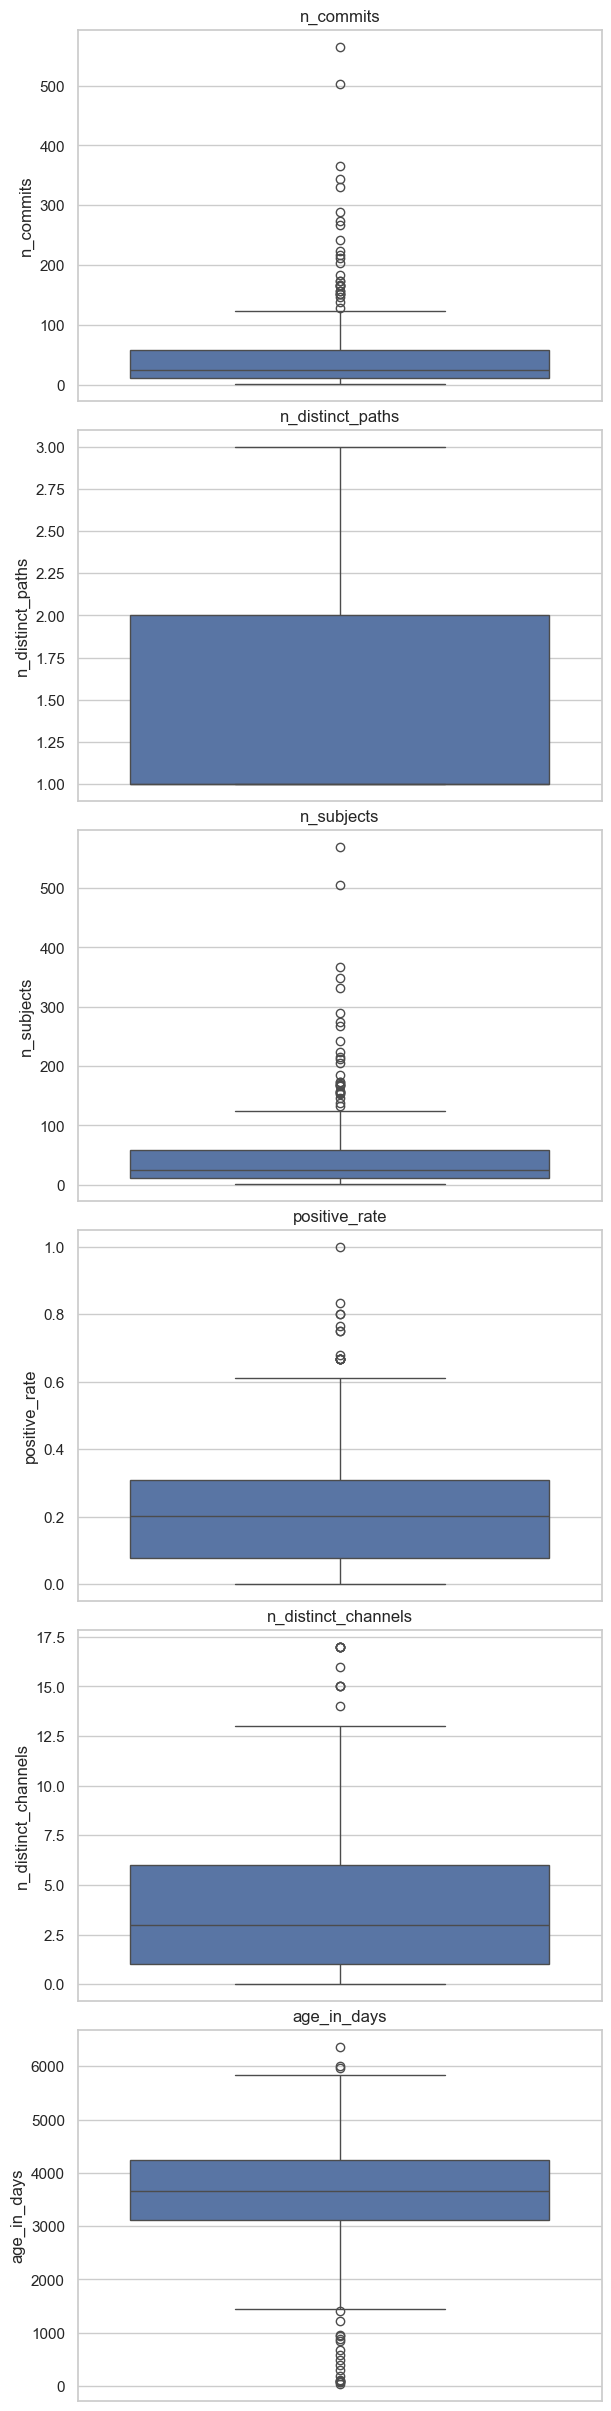

In [26]:
seaborn_boxplots(
    repo_summaries,
    columns=cols,
)

### Within a repo, Over the years…

In [27]:
group_keys = ["repo_age_group_index", "repo_age_group_at_commit"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_repos",
        "n_commits",
        "n_distinct_paths",
        "n_subjects",
        "positive_rate",
        "n_distinct_channels",
        "most_popular_path",
        "least_popular_path",
        "most_frequently_detected_channel",
        "least_commonly_detected_channel",
        "channel_pos_neg_breakdown",
    ),
    group_keys=tuple(group_keys),
)

repo_age_group_summary = (
    subjects
    .set_index(group_keys)
    .groupby(group_keys, dropna=False)
    .apply(lambda g: summarize_subjects_configurable(g, cfg))
    .reset_index()
    .drop(columns=["repo_age_group_index"])
)

repo_age_group_summary

,repo_age_group_at_commit,n_repos,n_commits,n_distinct_paths,n_subjects,positive_rate,n_distinct_channels,most_popular_path,least_popular_path,most_frequently_detected_channel,least_commonly_detected_channel,n_positives_with_channel,n_positives_without_channel,n_negatives_with_channel,n_negatives_without_channel
0,0-1,339,6335,5,6397,0.205878,32,README.md,contributing.md,form,reddit,562,755,627,4453
1,1-2,251,2421,4,2430,0.212346,29,README.md,README.txt,forum,skype,236,280,262,1652
2,2-3,216,1978,4,1995,0.202506,26,README.md,README.txt,website,youtube,198,206,206,1385
3,3-4,211,1423,5,1439,0.191800,26,README.md,README.txt,website,google_group,129,147,151,1012
4,4-5,173,1198,5,1214,0.215815,27,README.md,README.txt,issues,stack_overflow,132,130,123,829
5,5-6,138,1020,5,1024,0.230469,25,README.md,contributing.md,website,patreon,105,131,93,695
6,6-7,124,880,4,895,0.175419,26,README.md,README.txt,fork,medium,81,76,116,622
7,7-8,114,666,5,674,0.183976,25,README.md,contributing.md,telegram,facebook,59,65,113,437
8,8-9,92,578,3,586,0.191126,25,README.md,readme.md,telegram,medium,70,42,103,371
9,9-10,82,364,3,377,0.238727,25,README.md,readme.md,fork,facebook,47,43,47,240


### Further Path analysis

In [28]:
group_keys = ["path"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_repos",
        "n_commits",
        "n_subjects",
        "positive_rate",
        "n_distinct_channels",
        "most_frequently_detected_channel",
        "least_commonly_detected_channel",
        "channel_pos_neg_breakdown",
    ),
    group_keys=tuple(group_keys),
)

path_summaries = (
    subjects
    .set_index(group_keys)
    .groupby(group_keys, dropna=False)
    .apply(lambda g: summarize_subjects_configurable(g, cfg))
    .sort_values("n_subjects", ascending=False)
    .reset_index()
)

path_summaries

,path,n_repos,n_commits,n_subjects,positive_rate,n_distinct_channels,most_frequently_detected_channel,least_commonly_detected_channel,n_positives_with_channel,n_positives_without_channel,n_negatives_with_channel,n_negatives_without_channel
0,README.md,355,16172,16172,0.195709,32,website,meetup,1405,1760,1638,11369
1,CONTRIBUTING.md,99,909,909,0.333333,30,pull_request,facebook,232,71,199,407
2,readme.md,10,412,412,0.274272,19,form,github_issues,37,76,47,252
3,README.txt,15,174,174,0.229885,14,website,medium,16,24,22,112
4,contributing.md,3,27,27,0.185185,3,issues,fork,1,4,3,19


In [29]:
group_keys = ["path", "year"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_repos",
        "n_commits",
        "n_subjects",
        "positive_rate",
        "n_distinct_channels",
        "most_frequently_detected_channel",
        "least_commonly_detected_channel",
        "channel_pos_neg_breakdown",
    ),
    group_keys=tuple(group_keys),
)

path_year_summaries = (
    subjects_y
    .set_index(group_keys)
    .groupby(group_keys, dropna=False)
    .apply(lambda g: summarize_subjects_configurable(g, cfg))
    .reset_index()
)

path_year_summaries

,path,year,n_repos,n_commits,n_subjects,positive_rate,n_distinct_channels,most_frequently_detected_channel,least_commonly_detected_channel,n_positives_with_channel,n_positives_without_channel,n_negatives_with_channel,n_negatives_without_channel
0,CONTRIBUTING.md,2012,1.0,2.0,2.0,0.500000,4.0,fork,fork,1.0,0.0,0.0,1.0
1,CONTRIBUTING.md,2013,3.0,7.0,7.0,0.714286,11.0,issues,fork,5.0,0.0,1.0,1.0
2,CONTRIBUTING.md,2014,14.0,72.0,72.0,0.319444,17.0,pull_request,github_discussions,21.0,2.0,18.0,31.0
3,CONTRIBUTING.md,2015,16.0,54.0,54.0,0.240741,13.0,pull_request,mailing_list,13.0,0.0,14.0,27.0
4,CONTRIBUTING.md,2016,34.0,140.0,140.0,0.350000,22.0,pull_request,telegram,39.0,10.0,39.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,readme.md,2021,2.0,15.0,15.0,0.266667,5.0,form,gitter,2.0,2.0,1.0,10.0
57,readme.md,2022,2.0,12.0,12.0,0.250000,2.0,form,form,1.0,2.0,0.0,9.0
58,readme.md,2023,3.0,10.0,10.0,0.300000,2.0,mail,website,3.0,0.0,1.0,6.0
59,readme.md,2024,1.0,2.0,2.0,0.500000,2.0,gitter,gitter,1.0,0.0,0.0,1.0


In [30]:
group_keys = ["path", "full_name_of_repo"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_commits",
        "n_subjects",
        "positive_rate",
        "n_distinct_channels",
        "most_frequently_detected_channel",
        "least_commonly_detected_channel",
        "channel_pos_neg_breakdown",
    ),
    group_keys=tuple(group_keys),
)

path_repo_summaries = (
    subjects
    .set_index(group_keys)
    .groupby(group_keys, dropna=False)
    .apply(lambda g: summarize_subjects_configurable(g, cfg))
    .reset_index()
)

path_repo_summaries

,path,full_name_of_repo,n_commits,n_subjects,positive_rate,n_distinct_channels,most_frequently_detected_channel,least_commonly_detected_channel,n_positives_with_channel,n_positives_without_channel,n_negatives_with_channel,n_negatives_without_channel
0,CONTRIBUTING.md,Alignak-monitoring-contrib/alignak-webui,3.0,3.0,0.333333,3.0,github_issues,pull_request,1.0,0.0,1.0,1.0
1,CONTRIBUTING.md,Blecki/dwarfcorp,1.0,1.0,1.000000,2.0,fork,fork,1.0,0.0,0.0,0.0
2,CONTRIBUTING.md,GoogleCloudPlatform/python-docs-samples,14.0,14.0,0.500000,3.0,pull_request,issues,4.0,3.0,4.0,3.0
3,CONTRIBUTING.md,JessYanCoding/MVPArms,2.0,2.0,0.000000,2.0,fork,fork,0.0,0.0,1.0,1.0
4,CONTRIBUTING.md,KartikTalwar/gmail.js,1.0,1.0,1.000000,0.0,NaN,NaN,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
477,readme.md,gpimblott/TechRadar,2.0,2.0,0.000000,0.0,NaN,NaN,0.0,0.0,0.0,2.0
478,readme.md,guryanovev/CrystalQuartz,54.0,54.0,0.111111,7.0,gitter,form,2.0,4.0,13.0,35.0
479,readme.md,ifjorissen/vrfy,21.0,21.0,0.238095,3.0,form,form,1.0,4.0,3.0,13.0
480,readme.md,public-transport/hafas-client,122.0,122.0,0.508197,8.0,gitter,issues,13.0,49.0,2.0,58.0


In [31]:
group_keys = ["path", "repo_age_group_index", "repo_age_group_at_commit"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_repos",
        "n_commits",
        "n_subjects",
        "positive_rate",
        "n_distinct_channels",
        "most_frequently_detected_channel",
        "least_commonly_detected_channel",
        "channel_pos_neg_breakdown",
    ),
    group_keys=tuple(group_keys),
)

path_repo_age_group_summaries = (
    subjects
    .set_index(group_keys)
    .groupby(group_keys, dropna=False)
    .apply(lambda g: summarize_subjects_configurable(g, cfg))
    .reset_index()
)

path_repo_age_group_summaries

,path,repo_age_group_index,repo_age_group_at_commit,n_repos,n_commits,n_subjects,positive_rate,n_distinct_channels,most_frequently_detected_channel,least_commonly_detected_channel,n_positives_with_channel,n_positives_without_channel,n_negatives_with_channel,n_negatives_without_channel
0,CONTRIBUTING.md,0,0-1,45.0,190.0,190.0,0.289474,19.0,pull_request,google_group,47.0,8.0,45.0,90.0
1,CONTRIBUTING.md,1,1-2,27.0,96.0,96.0,0.229167,19.0,pull_request,forum,18.0,4.0,37.0,37.0
2,CONTRIBUTING.md,2,2-3,28.0,92.0,92.0,0.391304,18.0,pull_request,mailing_list,30.0,6.0,15.0,41.0
3,CONTRIBUTING.md,3,3-4,28.0,69.0,69.0,0.492754,20.0,pull_request,mailing_list,25.0,9.0,10.0,25.0
4,CONTRIBUTING.md,4,4-5,28.0,90.0,90.0,0.333333,15.0,pull_request,discord,26.0,4.0,20.0,40.0
5,CONTRIBUTING.md,5,5-6,25.0,61.0,61.0,0.377049,17.0,pull_request,discord,15.0,8.0,16.0,22.0
6,CONTRIBUTING.md,6,6-7,22.0,55.0,55.0,0.181818,13.0,pull_request,mail,9.0,1.0,12.0,33.0
7,CONTRIBUTING.md,7,7-8,25.0,56.0,56.0,0.303571,17.0,pull_request,slack,11.0,6.0,17.0,22.0
8,CONTRIBUTING.md,8,8-9,17.0,68.0,68.0,0.279412,14.0,pull_request,irc,14.0,5.0,13.0,36.0
9,CONTRIBUTING.md,9,9-10,21.0,55.0,55.0,0.454545,18.0,pull_request,stack_overflow,14.0,11.0,6.0,24.0


In [35]:
subjects_y["suffix"] = (
    df["path"]
    .astype("string")
    .str.extract(r"\.([^.]+)$")
)

group_keys = ["suffix", "year"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_repos",
        "n_commits",
        "n_subjects",
        "positive_rate",
        "n_distinct_channels",
        "most_frequently_detected_channel",
        "least_commonly_detected_channel",
        "channel_pos_neg_breakdown",
    ),
    group_keys=tuple(group_keys),
)

suffix_summaries = (
    subjects_y
    .set_index(group_keys)
    .groupby(group_keys, dropna=False)
    .apply(lambda g: summarize_subjects_configurable(g, cfg))
    .reset_index()
)

suffix_summaries

,suffix,year,n_repos,n_commits,n_subjects,positive_rate,n_distinct_channels,most_frequently_detected_channel,least_commonly_detected_channel,n_positives_with_channel,n_positives_without_channel,n_negatives_with_channel,n_negatives_without_channel
0,md,2008,1.0,3.0,3.0,0.333333,3.0,mail,mail,1.0,0.0,0.0,2.0
1,md,2009,2.0,32.0,32.0,0.125000,3.0,website,mail,1.0,3.0,2.0,26.0
2,md,2010,6.0,51.0,52.0,0.134615,11.0,form,jira,6.0,1.0,14.0,31.0
3,md,2011,9.0,49.0,50.0,0.160000,9.0,form,linkedin,4.0,4.0,13.0,29.0
4,md,2012,25.0,241.0,243.0,0.234568,15.0,form,google_group,18.0,39.0,15.0,171.0
5,md,2013,70.0,636.0,637.0,0.254317,20.0,website,github_wiki,87.0,75.0,66.0,409.0
6,md,2014,123.0,1403.0,1418.0,0.210155,26.0,website,skype,144.0,154.0,166.0,954.0
7,md,2015,175.0,1897.0,1916.0,0.207724,23.0,fork,gitter,177.0,221.0,216.0,1302.0
8,md,2016,217.0,2891.0,2916.0,0.190672,29.0,fork,skype,263.0,293.0,295.0,2065.0
9,md,2017,241.0,2529.0,2549.0,0.196155,29.0,form,reddit,216.0,284.0,215.0,1834.0


### Further Channel analysis

- overall:
    - top N most often detected channels
    - top N rarest channels
- per year:
    - top N most often detected channels – race of the channels…
    - top N rarest channels
- per repo age group:
    - top N most often detected channels
    - top N rarest channels
- for each distinct channel:
    - first time
    - last time
    - How many repos?
    - How many subjects?
    - …

### Correlations?

- What indicates a higher ccdc_rate?
    - The year?
    - The age of the repo?
    - The number of channels in use??
    - The ccdc_rate itself???
    - The number of channels detected for that subject?